In [ ]:
!pip install jsonpath_ng


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import os
import json
import numpy as np
import pandas as pd
import sqlite3
import functools as ft
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from jsonpath_ng import parse
from enum import Enum
from datetime import datetime
%matplotlib inline

## Reading the tables after ETL

### Fact table

All the tables appearing in this section have undergone ETL and are free of data defects. In addition, the data presented in the tables are sorted by patient number and by date to produce a time-based timeline for a patient.

In [ ]:
Fact_After_ETL = pd.read_excel('Fact_After_ETL.xlsx')
Fact_After_ETL

,Date,Patient Number,Age,Routine Test
0,2005-06-30,1,75,1
1,2005-06-30,1,75,0
2,2005-07-08,1,75,1
3,2005-07-08,1,75,0
4,2005-10-24,1,75,1
...,...,...,...,...
96643,2019-11-21,300,90,0
96644,2019-12-17,300,90,1
96645,2019-12-17,300,90,0
96646,2019-12-26,300,90,1


### General details table

In [ ]:
General_details_After_ETL = pd.read_excel('General_details_After_ETL.xlsx')
General_details_After_ETL

,Date,Patient Number,Routine test,age,sex,weight,height,Smoker
0,2005-06-30,1,1,75,1,59.306449,151,0
1,2005-06-30,1,0,75,1,59.306449,151,0
2,2005-07-08,1,1,75,1,59.970350,151,0
3,2005-07-08,1,0,75,1,59.970350,151,0
4,2005-10-24,1,1,75,1,64.119390,151,1
...,...,...,...,...,...,...,...,...
98543,2019-11-21,300,0,90,1,82.255023,158,1
98544,2019-12-17,300,1,90,1,83.482713,158,0
98545,2019-12-17,300,0,90,1,83.482713,158,0
98546,2019-12-26,300,1,90,1,80.337148,158,0


### Additional Hos table

In [ ]:
Additional_Hospitalization_After_ETL = pd.read_excel('Additional_Hospitalization_After_ETL.xlsx')
Additional_Hospitalization_After_ETL

,Date,Patient Number,Routine test,startIshpuz,endIshpuz,procedures,simulation
0,2005-06-30,1,1,2017-10-06,2017-10-11,2,5
1,2005-07-08,1,1,2017-10-06,2017-10-11,2,5
2,2005-10-24,1,1,2017-10-06,2017-10-11,2,5
3,2006-01-08,1,1,2017-10-06,2017-10-11,2,5
4,2006-02-02,1,1,2017-10-06,2017-10-11,2,5
...,...,...,...,...,...,...,...
48324,2019-10-09,300,1,2011-04-18,2011-04-22,3,4
48325,2019-11-19,300,1,2011-04-18,2011-04-22,3,4
48326,2019-11-21,300,1,2011-04-18,2011-04-22,3,4
48327,2019-12-17,300,1,2011-04-18,2011-04-22,3,4


### Death reasons table

In [ ]:
Death_reasons_After_ETL = pd.read_excel('Death_reasons_After_ETL.xlsx')
Death_reasons_After_ETL

,Date,Patient Number,isDead,Routine test,DeathReason
0,2019-12-16,2,1,1,Kidney disease
1,2019-12-26,12,1,1,Septicemia
2,2019-12-31,15,1,1,Septicemia
3,2019-11-05,20,1,1,Liver disease
4,2019-08-22,31,1,1,Other causes
...,...,...,...,...,...
61,2019-12-24,281,1,0,Septicemia
62,2019-12-21,285,1,0,Cerebrovascular disease
63,2019-10-06,286,1,0,Anemias
64,2019-12-15,291,1,0,Hypertension


## Queries

**Note:**

Due to the fact that the data is engineered and not real, there are many gaps and duplicates that affect the displayed query outputs. For this reason and because the output obtained is partial and does not reflect, we did not see fit to draw general conclusions. However, at the end of each query, state what insights and conclusions the customer can derive from performing them. In order to maintain the quality and reliability of the project, we could not analyze which characteristics most influence hospitalization or death among the given population based on the received outputs.

### query 1

Calculation of the duration between each test or hospitalization that each patient had

In [ ]:
Fact_After_ETL['duration'] = Fact_After_ETL.groupby('Patient Number')['Date'].diff()
Fact_After_ETL

,Date,Patient Number,Age,Routine Test,duration
0,2005-06-30,1,75,1,NaT
1,2005-06-30,1,75,0,0 days
2,2005-07-08,1,75,1,8 days
3,2005-07-08,1,75,0,0 days
4,2005-10-24,1,75,1,108 days
...,...,...,...,...,...
96643,2019-11-21,300,90,0,0 days
96644,2019-12-17,300,90,1,26 days
96645,2019-12-17,300,90,0,0 days
96646,2019-12-26,300,90,1,9 days


### query 2

Use the result of query 1 and display the patients who were admitted and had their last routine checkup more than 700 days ago. The user will likely use this query to filter out outliers.

In [ ]:
temp = Fact_df_sorted[Fact_df_sorted['Routine Test']==1]
Outliers = temp[temp['duration'] > pd.Timedelta(days=700)]
Outliers

,Date,Patient Number,Age,Routine Test,duration
2992,2011-06-12,7,86,1,774 days
3922,2015-06-25,9,76,1,710 days
6050,2012-12-08,14,68,1,802 days
7516,2009-04-20,21,82,1,873 days
9508,2017-07-02,30,75,1,704 days
13270,2011-08-15,45,78,1,706 days
13286,2018-06-04,45,78,1,721 days
27736,2011-06-07,78,83,1,711 days
27750,2016-01-30,78,83,1,775 days
30387,2019-01-11,86,97,1,838 days


**conclusion:**
This query displays the selected filter value for not referring to a hospitalization line due to the fact that the last test line necessarily resulted in hospitalization. We note that the selection of the value is a np_hard problem that affects the data that will be presented to the client. In addition, in the ETL process, we filtered outliers for 900 days, we presented here for 700 days so that an output is shown to the user. The number of days will be subject to the customer's decision to allow him to choose the number of days he would like to filter.

### query 3

The number of patients who died by age

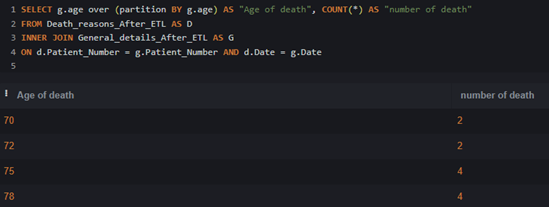

**conclusion:**
The client will be able to characterize whether more deaths occurred at a certain age than at other ages and thus analyze the data of the test results in a targeted manner.

### query 4

The number of patients who died by cause of death

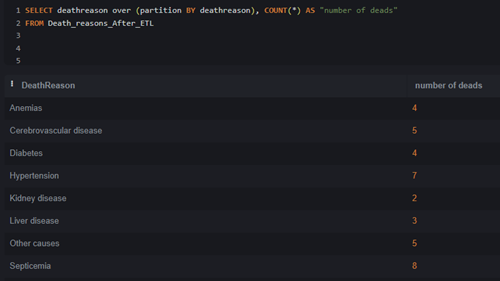

**conclusion:**
The client will be able to characterize whether more deaths occurred due to a certain cause of death than and thereby analyze the data of the results of the subjects who died from the same cause of death in a targeted manner.

### query 5

 The ratio between the number of hospitalizations and the number of lines (medical tests) that appear for the patient - (KPI1.1)

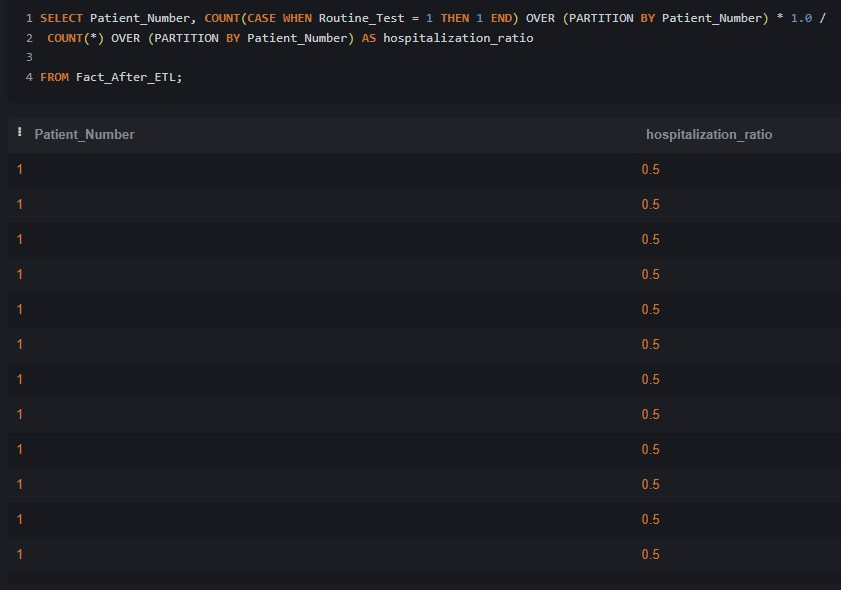

**conclusion:**
Realizing the KPI and drawing the appropriate conclusions as formulated in the first question in the project.

### query 6

This query retrieves the number of patients from a table Fact_After_ETL that did not make any hospitalizations.
Most likely the client would like to filter them.

SELECT DISTINCT patient_number

FROM Fact_After_ETL

WHERE patient_number NOT IN (SELECT DISTINCT patient_number FROM Additional_Hospitalization_After_ETL)


### query 7

This query will return for each patient the age at which their first row of data is located and the age for their last row of data.

SELECT
    patient_number,

    MAX(Age) OVER (PARTITION BY patient_number) AS MaxAge,

    MIN(Age) OVER (PARTITION BY patient_number) AS MinAge
    
FROM
    General_details_After_ETL


### query 8

Average length of hospitalization

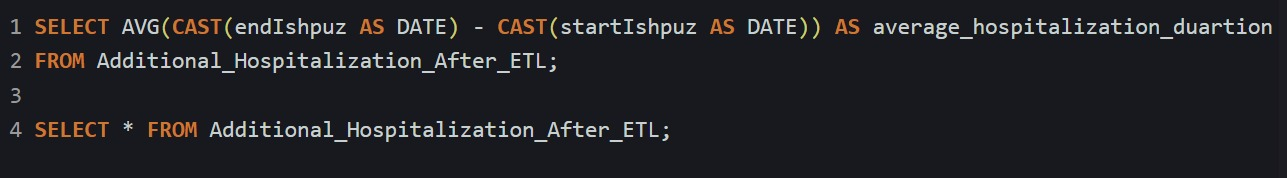

**conclusion:**
The average length of hospitalization is an important figure by which the customer can estimate the average cost of hospitalization for his insured customers in terms of money.
This figure will support the project's goal of reducing the amount of hospitalizations in the future.

### query 9

Showing the amount of hospitalizations performed for patients by age.

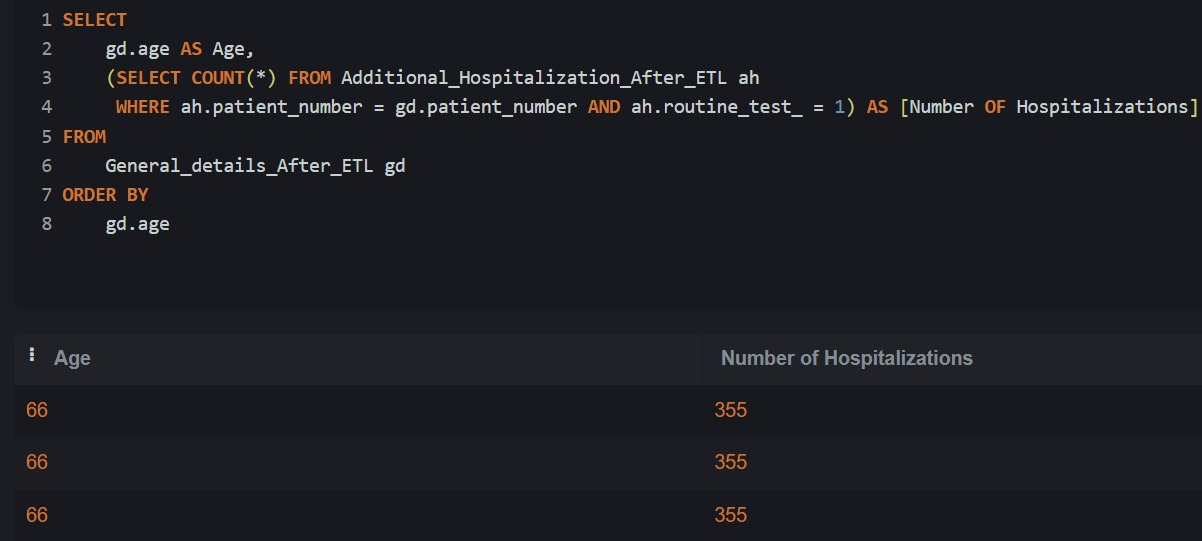

**conclusion:**
Using the output of this query, the client will be able to focus on the age group where the number of hospitalizations is the greatest and try to characterize and analyze the results of the data and tests for that age population.

### query 10

Showing the amount of routine tests performed for patients by age.

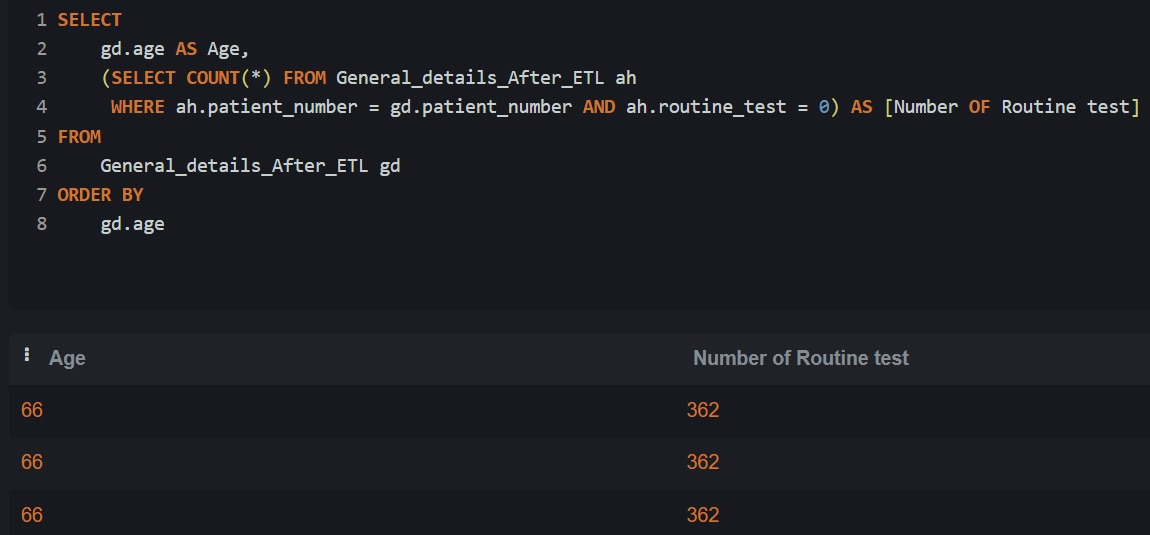

**Conclusion:** Following query number 8, the client can focus on the age group in which the most tests were performed and try to characterize and analyze the results of the data and tests for the age population with the highest risk of hospitalization.